# Inference

## Project: Image Captioning

---

In this notebook, I will use the trained model to generate captions for images in the test dataset.

## Getting Data Loader for Test Dataset


In [1]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])


# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


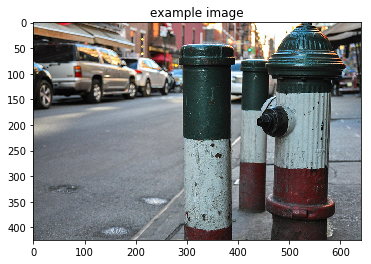

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

## Loading Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

encoder_file = 'encoder-1.pkl'
decoder_file = 'decoder-1.pkl'

embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 67811729.01it/s]


DecoderRNN(
  (embed): Embedding(8855, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=8855, bias=True)
)

The next cell should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).
 

In [5]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)
print(image.shape)
print(orig_image.shape)
# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

torch.Size([1, 3, 224, 224])
torch.Size([1, 425, 640, 3])
example output: [0, 3, 165, 166, 130, 394, 39, 3, 33, 564, 18, 1, 1, 18, 1, 1, 39, 32, 185, 18]


In [6]:
def clean_sentence(output):
    sentence = ''
    for i in output:
        word = data_loader.dataset.vocab.idx2word[i]
        if i == 0:
            continue
        if i == 1:
            break
        if i == 18:
            sentence = sentence + word
        else:
            sentence = sentence + ' ' + word
    
    return sentence.strip()
    return sentence

In [7]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a fire hydrant is painted on a street corner.


## Generating Predictions!

In the code cell below, I have written a function (`get_prediction`) that can be used to loop over images in the test dataset and print the model's predicted caption.

In [8]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

all the action of this function in the next cell!

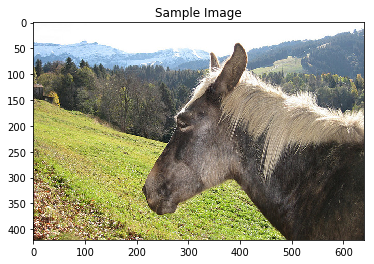

a horse is standing in the grass near a tree.


In [18]:
get_prediction()

### Some predictions

In the next few cells, I have made some predctions to see how it performs, there is  a big room for improvement, but for now I am happy with the result.

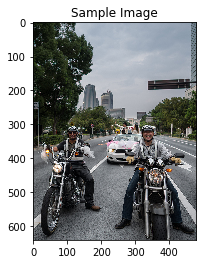

a man riding a motorcycle down a street.


In [13]:
get_prediction()

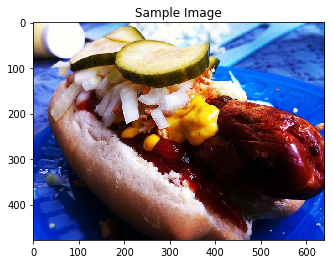

a sandwich with a lot of toppings on it.


In [21]:
get_prediction()

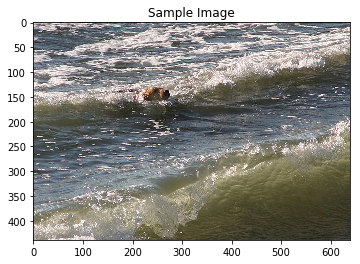

a man in a wetsuit windsurfs on a surfboard.


In [23]:
get_prediction()